In [1]:
%load_ext autoreload
%autoreload 2
from mmpp import MMPP

In [2]:
op=MMPP("/zfn2/mannga/jobs/vortices/spectrum/d100_sinc4.zarr")
lista = op.scan(force=True)

[13:46:41] INFO     mmpp | INFO | Loaded single zarr file: /zfn2/mannga/jobs/vortices/spectrum/d100_sinc4.zarr

In [3]:
op=MMPP("/mnt/storage_2/scratch/pl0095-01/zelent/mannga/Pawel/bowtie_film_sweep_2.14GHz/MZ/v1")
lista = op.scan(force=False)

[13:35:00] INFO     mmpp | INFO | Loaded existing database from:                                                   
                    /mnt/storage_2/scratch/pl0095-01/zelent/mannga/Pawel/bowtie_film_sweep_2.14GHz/MZ/v1/mmpy_datab
                    ase.pkl

           INFO     mmpp | INFO | Database already loaded. Use force=True to rescan.

In [ ]:
op[0].fft.modes.plot

In [ ]:
%matplotlib widget 
op[0].mpl.snapshot(dset="m_z11-14",z=-1)

In [3]:
op[0].p

[13:46:43] INFO     mmpp | INFO | Database: d100_sinc4, Structure: /                                               
                     ├── alpha (1, 11, 1296, 1296, 1) float32                                                      
                     ├── fft                                                                                       
                     │   ├── freq                                                                                  
                     │   ├── m_z5-8_z0_m1                                                                          
                     │   │   ├── frequencies (300,) float64                                                        
                     │   │   └── spectrum (300, 3) float64                                                         
                     │   └── spectrum                                                                              
                     ├── m_z5-8 (599, 3, 1296, 1296, 3) float32                                                    
                     └── m_z5-8_z-1_m1                                                                             
                         ├── frequencies (300,) float64                                                            
                         └── spectrum (300, 3) float64

[13:47:16] INFO     mmpp.fft | INFO | Loaded existing FFT data in 0.029s, spectrum shape: (300, 3)

           INFO     mmpp.fft | INFO | ✓ Loaded existing FFT data for m_z5-8_z0_m1 (parameters verified)

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Power Spectrum - m_z5-8 (Method 1)'}, xlabel='Frequency (GHz)', ylabel='FFT Amplitude($10^{-6}$ arb. units)'>)

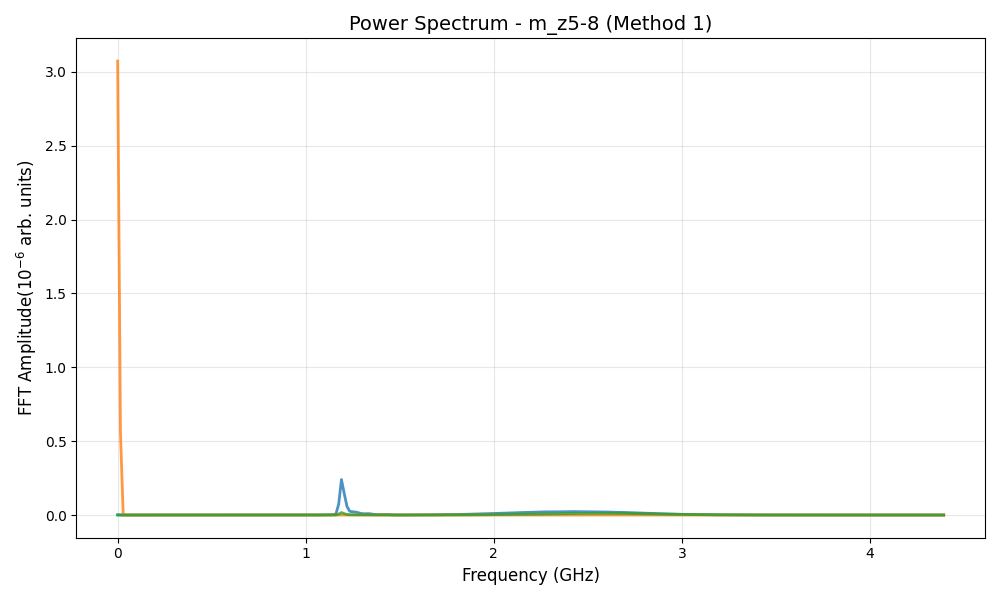

In [7]:
%matplotlib widget
op[0].fft.plot_spectrum(
    dset="m_z5-8",
    z=0, # Dataset name
    method=1, # FFT method
    z_layer=0, # Z-layer (-1 for last layer)
    window="hamming",
    log_scale=False, # Use logarithmic scale
    # normalize=True,
    # save=True, # Whether to save the plot
    force=False # Don't force - check if cache works
)

In [10]:
op[0].fft.modes.compute_modes(dset="m_z5-8")
fig, axes = op[0].fft.modes.plot_modes(
    frequency=2.5,
    dset="m_z5-8", 
    # z_layer=0,
    # figsize=(15, 10),
    # show_combined=True,  # Pokaż combined plot (phase + magnitude)
    # component='all',     # Wszystkie komponenty (x, y, z)
    # normalize=True,
    # save_path="modes_2.5GHz.png"  # Zapisz do pliku
)

[13:47:38] INFO     mmpp.fft.modes | INFO | Opened zarr file: /zfn2/mannga/jobs/vortices/spectrum/d100_sinc4.zarr

ValueError: No mode data found for dataset 'm_z5-8'. Expected paths: ['modes/m_z5-8/arr', 'tmodes/m_z5-8/arr']

In [ ]:
import zarr
a = zarr.open_group("/zfn2/mannga/jobs/vortices/spectrum/d100_sinc4.zarr", mode="r")["m_z5-8"][:]

In [ ]:
# Krok 1: Sprawdź dostępne datasety
import zarr
zarr_store = zarr.open(op[0].path, mode='r')
print("Dostępne datasety w zarr:")
for key in zarr_store.keys():
    if 'm_' in key:
        print(f"  {key}: {zarr_store[key].shape}")

# Krok 2: Sprawdź czy istnieją obliczone mody
try:
    if 'modes' in zarr_store:
        print("\nIstniejące mody:")
        for key in zarr_store['modes'].keys():
            print(f"  modes/{key}")
    else:
        print("\nBrak obliczonych modów")
except:
    print("\nBrak katalogu modes")

In [ ]:
# Krok 3: Oblicz mody FMR dla datasetu m_z5-8
from mmpp.fft.modes import FMRModeAnalyzer

# Utwórz analizator modów dla konkretnego datasetu
analyzer = FMRModeAnalyzer(
    zarr_path=op[0].path,
    dataset_name="m_z5-8",  # Konkretny dataset
    debug=True
)

print(f"Analizator utworzony dla datasetu: {analyzer.dataset_name}")

# Sprawdź czy mody już istnieją
if not analyzer.modes_available:
    print("Obliczam mody FMR z danych czasowych...")
    
    # Oblicz mody (może potrwać chwilę dla dużych danych)
    analyzer.compute_modes(
        z_slice=slice(None),  # Wszystkie warstwy z
        window=True,          # Okno Hanninga dla lepszego FFT
        save=True,           # Zapisz wyniki w zarr
        chunk_size=(50, 50)  # Rozmiar chunków dla zarr
    )
    print("Mody obliczone i zapisane!")
else:
    print("Mody już istnieją w danych!")

In [ ]:
# Krok 4: Teraz wyświetl mody!

# Sprawdź dostępne częstotliwości
frequencies = analyzer.frequencies
print(f"Dostępne częstotliwości: {frequencies[0]:.3f} - {frequencies[-1]:.3f} GHz")
print(f"Liczba próbek: {len(frequencies)}")

# Znajdź częstotliwość najbliższą 2.5 GHz
target_freq = 2.5
closest_idx = np.argmin(np.abs(frequencies - target_freq))
actual_freq = frequencies[closest_idx]
print(f"Najbliższa częstotliwość do {target_freq} GHz: {actual_freq:.3f} GHz")

# Wyświetl mody dla tej częstotliwości
fig, axes = analyzer.plot_modes(
    frequency=actual_freq,
    z_layer=0,
    figsize=(15, 10),
    normalize=True,
    save_path=f"modes_{actual_freq:.3f}GHz.png"
)

plt.show()

In [ ]:
# Krok 5: Interaktywne spektrum z modami
print("Uruchamiam interaktywne spektrum...")
print("INSTRUKCJE:")
print("- Lewy klik: wybierz dowolną częstotliwość")
print("- Prawy klik: snap do najbliższego piku")
print("- Zamknij okno gdy skończysz")

# Uruchom interaktywne spektrum
fig = analyzer.interactive_spectrum(
    z_layer=0,
    figsize=(16, 8),
    components=['x', 'y', 'z']  # Pokaż wszystkie komponenty
)

plt.show()

In [ ]:
# Test naprawionej funkcjonalności plot_modes
print("🔧 Test: plot_modes z automatycznym obliczaniem modów")

# To powinno teraz działać - automatycznie obliczy mody dla m_z5-8 jeśli nie istnieją
try:
    fig, axes = op[0].fft.modes.plot_modes(
        frequency=2.5,
        dset="m_z5-8",  # Konkretny dataset
        z_layer=0,
        figsize=(15, 10),
        normalize=True,
        save_path="modes_2.5GHz_auto.png"
    )
    print("✅ Sukces! plot_modes działa z automatycznym obliczaniem")
    plt.show()
    
except Exception as e:
    print(f"❌ Błąd: {e}")
    print("Prawdopodobnie nadal trzeba ręcznie obliczyć mody")

In [ ]:
# Alternatywna metoda: ręczne obliczenie modów
print("🔧 Alternatywa: ręczne obliczenie modów przez interface")

# Oblicz mody dla konkretnego datasetu
try:
    print("Obliczam mody dla m_z5-8...")
    op[0].fft.modes.compute_modes(
        dset="m_z5-8",
        z_slice=slice(None),  # Wszystkie warstwy z
        window=True,          # Okno Hanninga
        save=True            # Zapisz w zarr
    )
    print("✅ Mody obliczone!")
    
    # Teraz spróbuj wyświetlić
    fig, axes = op[0].fft.modes.plot_modes(
        frequency=2.5,
        dset="m_z5-8",
        z_layer=0,
        figsize=(15, 10),
        normalize=True
    )
    print("✅ Wizualizacja udana!")
    plt.show()
    
except Exception as e:
    print(f"❌ Błąd w alternatywnej metodzie: {e}")
    print("\nSpróbuj poprzednią metodę z FMRModeAnalyzer bezpośrednio")